# Abstract:
This notebook uses the master dataset 'master_track_data.csv', which was modified from the original 'track.csv' file which includes about 600,000 Spotify tracks and their ids, artist list, popularity, release date, and additional audio qualities. The process of cleaning the original data and feature engineering new columns such as 'decade' or 'language' can be found in the notebook 'data_cleaning.ipynb.' Because of the size of the dataset and the time required for this process, the two notebooks have been separated so that the analysis process can be replicated quickly using the final data set. 

This notebook analyzes Spotify track data in order to gain insight on how to build effective music recommendation systems that better recommend international music. First, it looks at the distribution and correlation of different features. It shows that after 2010, non-English music surpasses English music in average popularity, and the gap continues to widen until 2020 where our dataset ends. 

This notebook then executes a KMeans Clustering algorithm to identify patterns in the dataset. By using a Random Forest Classifier, it uncovers the most important features in the cluster splits. From this process we see that the decade in which a track was released appeared to be the most relevant feature to determine which cluster a track belonged to, while the language feature didn't appear in the top ten features of any cluster. 

Because of our findings about the rise of non-English music and language's lack of importance in predicting audio qualities, the language features are then dropped from the dataset. It then creates a simple content-based recommendation system that takes a single target track and finds the most similar items by calculating cosine similarity. Using an example English-language track, the system finds both English and non-English tracks with up to 99% similarity, suggesting that recommender systems can give users tracks that are similar to what they enjoy without perpetuating a bias towards non-English artists. 

# Data Analysis

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tracks = pd.read_csv('data/master_track_data.csv', index_col=0)
tracks.reset_index(drop=True, inplace=True)
pd.set_option('display.max_columns', None)

In [17]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586547 entries, 0 to 586546
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586547 non-null  object 
 1   name              586546 non-null  object 
 2   popularity        586547 non-null  int64  
 3   duration_ms       586547 non-null  int64  
 4   explicit          586547 non-null  int64  
 5   artists           586547 non-null  object 
 6   id_artists        586547 non-null  object 
 7   danceability      586547 non-null  float64
 8   energy            586547 non-null  float64
 9   key               586547 non-null  int64  
 10  loudness          586547 non-null  float64
 11  mode              586547 non-null  int64  
 12  speechiness       586547 non-null  float64
 13  acousticness      586547 non-null  float64
 14  instrumentalness  586547 non-null  float64
 15  liveness          586547 non-null  float64
 16  valence           58

#### Explore type of audio tracks:
According to Spotify API: "Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks."


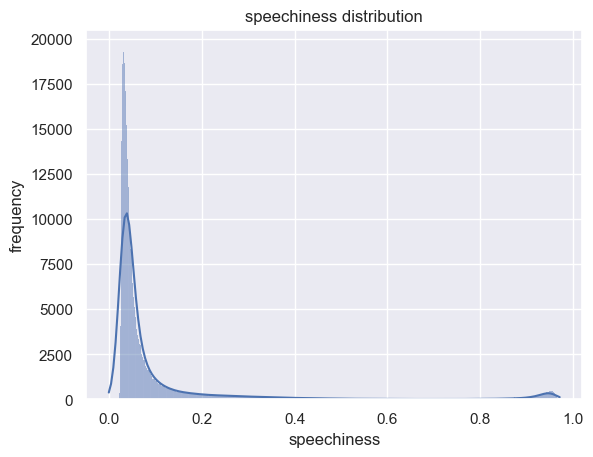

In [18]:
#plot distribution of 'speechiness' feature 
sns.histplot(tracks['speechiness'], kde=True)
plt.xlabel('speechiness')
plt.ylabel('frequency')
plt.title('speechiness distribution')
plt.show();

In [19]:
#a smaller peak towards the higher end of speechiness indicated we have a small amount of audiobooks/spoken word tracks

print(len(tracks[tracks['speechiness'] > .66]))
print(len(tracks[tracks['speechiness'] > .66]) / len(tracks))

22598
0.03852717685027798


In [20]:
len(tracks[(tracks['speechiness'] < .66) & (tracks['speechiness'] > .33)])
#14,931 tracks fall in the middle (like rap music) 
len(tracks[(tracks['speechiness'] < .66) & (tracks['speechiness'] > .33)]) / len(tracks)
#this is only about .025% of the data 

0.025443826325938074

Only about .04% of our data falls into the audiobook/spoken word cateogry, and only about .025% falls into the middle category. This means the vast majority (~93.5%) of our data is considered 'music or other non-speech track.'

#### Explore correlation between numerical variables: 

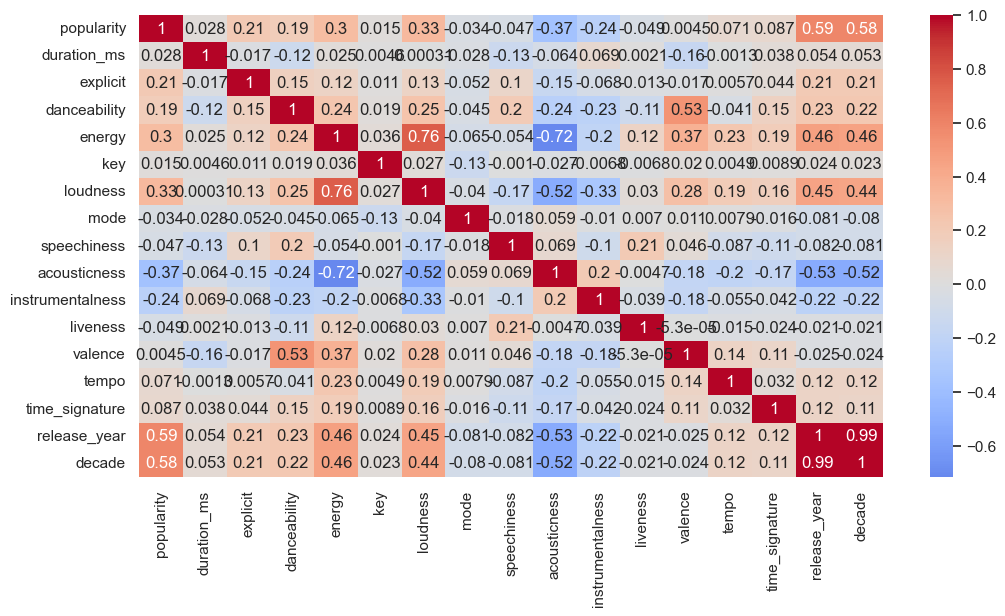

In [21]:
#plot a pearson correlation matrix

correlation_matrix = tracks.corr(numeric_only=True)
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0);

Of course 'decade' and 'release year' are highly correlated, so we will only keep the 'decade' category for our modeling. The other variables that seem to be highly correlated are energy & loudness (.76) and energy & acousticness (-.72). We might consider removing 'energy' if there seems to be multi-colinearity.

#### Explore distribution of variables:

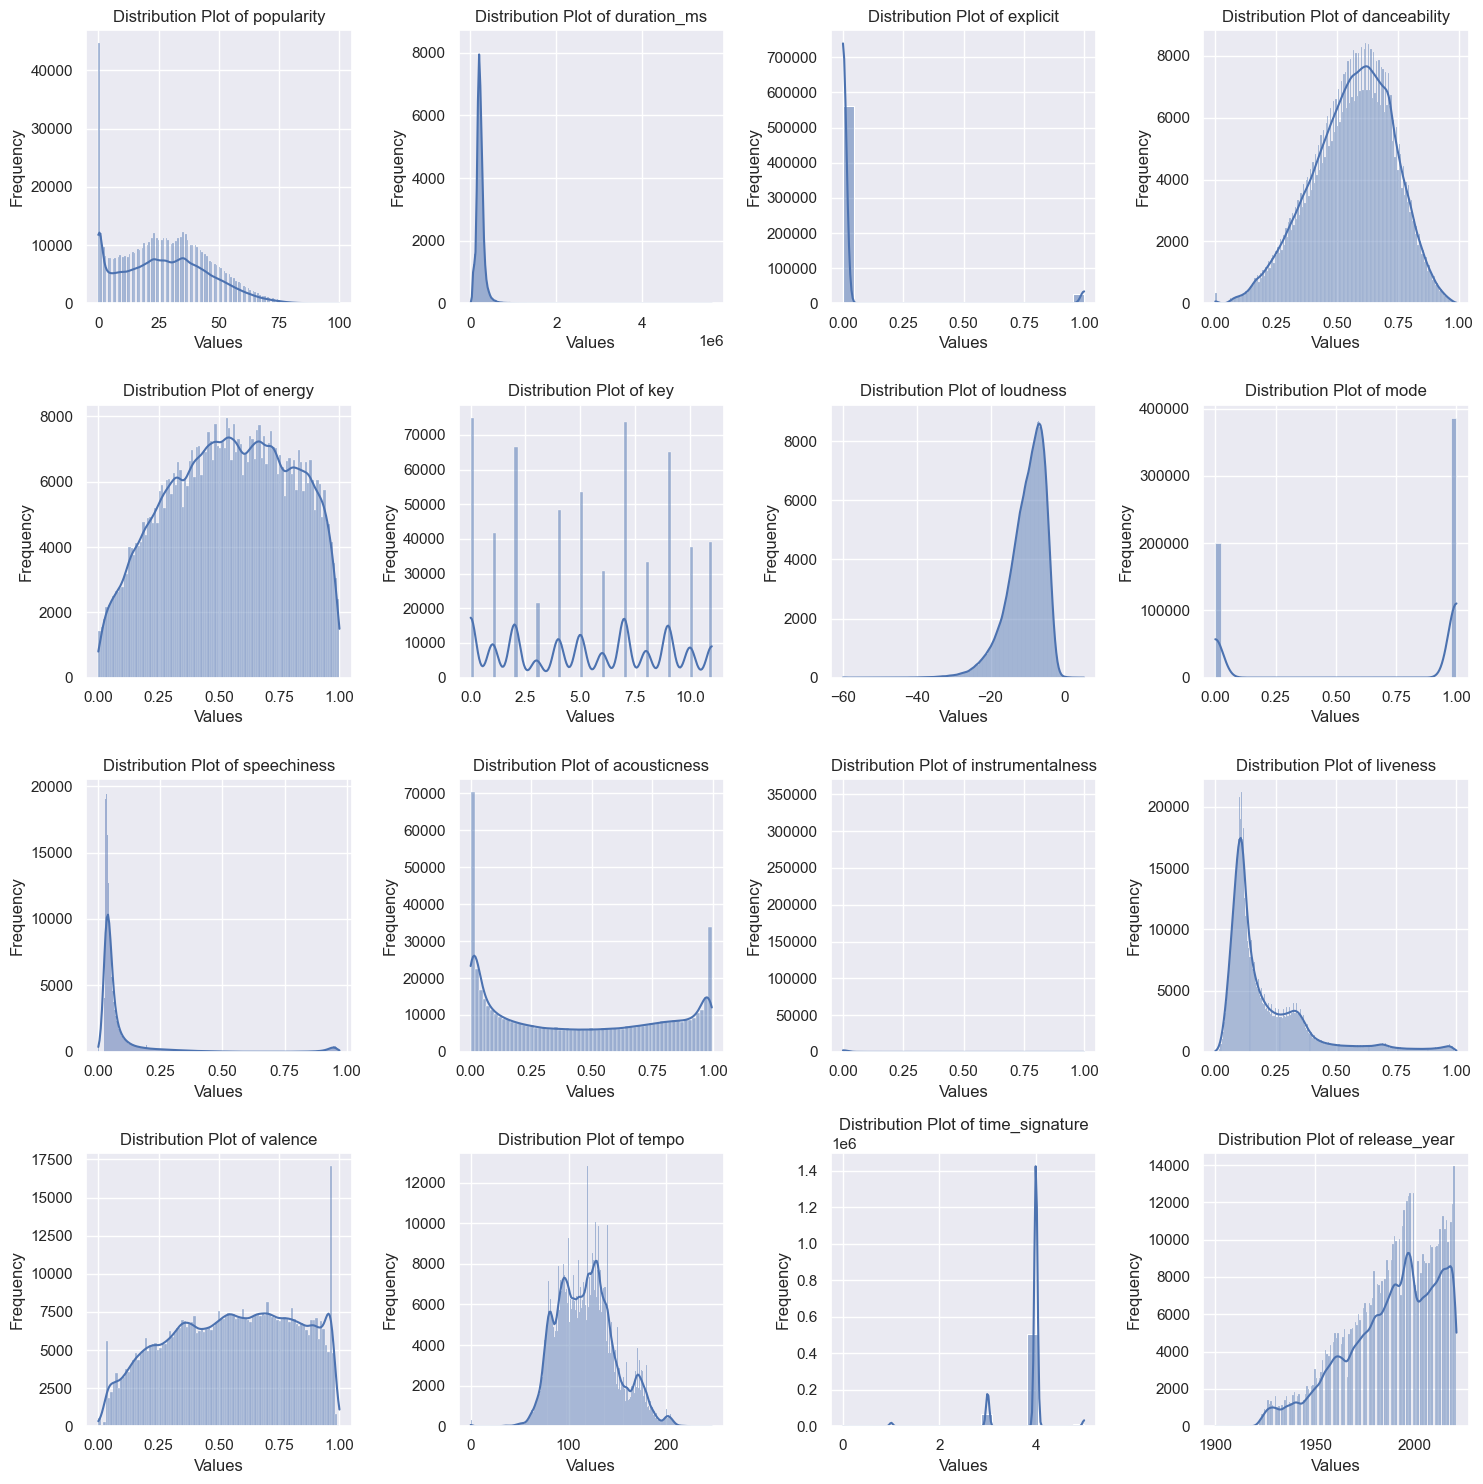

In [22]:
#plot ditributions of numerical columns

cols = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature',
       'release_year']

fig, axes = plt.subplots(figsize=(15, 15), nrows=4, ncols=4)


for i, column in enumerate(cols):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    sns.histplot(tracks[column], kde=True, ax=ax)
    ax.set_title(f'Distribution Plot of {column}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

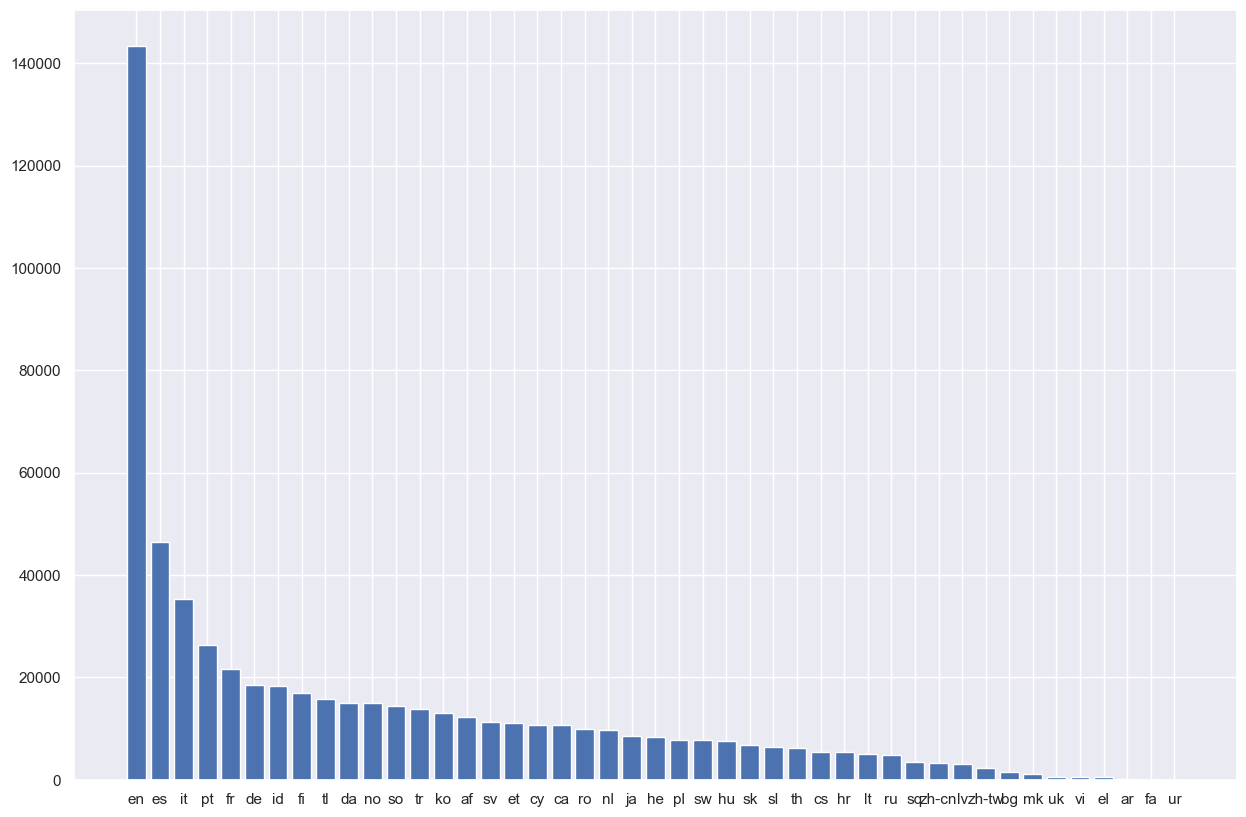

In [23]:
#plot bar chart of languages 

fig, ax = plt.subplots(figsize=(15,10))
x=tracks['name_language'].value_counts().index
y=tracks['name_language'].value_counts().values

plt.bar(x, y);

While some of our features follow relatively normal distributions, some are highly skewed, such as speechiness, release year, and liveness. 

Also, while English is the most popular language, it does not make up a majority in our dataset, and in fact there is a wide distribution of languages present in the data. 

### Language / Decade Exploration 

In [24]:
#create a binary column for whether or not a track is in English 
tracks['en'] = tracks['name_language'].apply(lambda x: 1 if x=='en' else 0)
tracks['en'].value_counts(normalize=True)

0    0.755745
1    0.244255
Name: en, dtype: float64

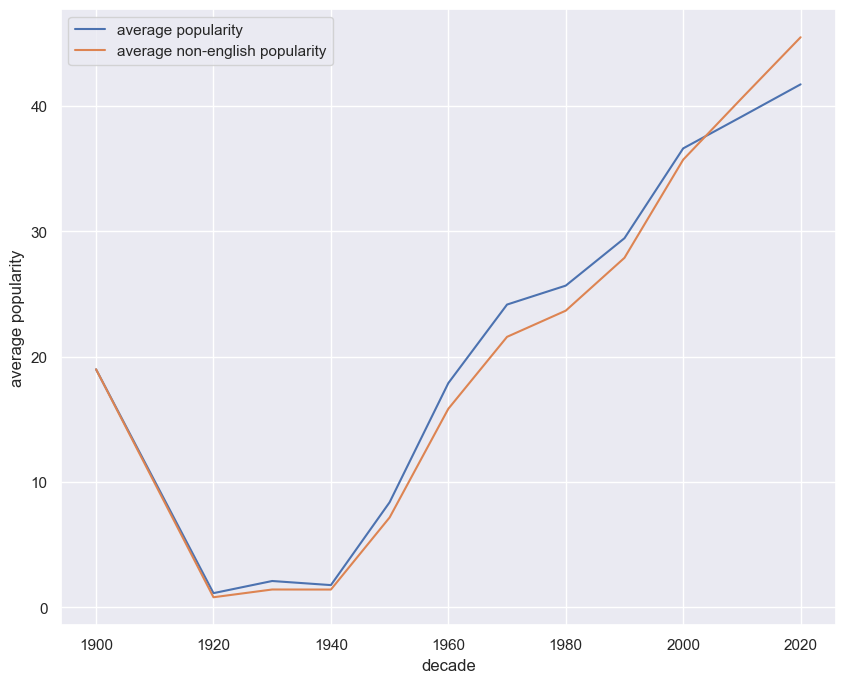

In [25]:
#plot the average popularity of tracks for each decade for all tracks and non-english tracks
decade_pop = tracks.groupby('decade')['popularity'].mean()
decade_non_en_pop = tracks[tracks['en'] == 0].groupby('decade')['popularity'].mean()

sns.set(style='darkgrid')
plt.figure(figsize=(10,8))
sns.lineplot(x=decade_pop.index, y=decade_pop.values, label='average popularity')
sns.lineplot(x=decade_non_en_pop.index, y=decade_non_en_pop.values, label='average non-english popularity')
plt.xlabel("decade")
plt.ylabel("average popularity")
plt.legend
plt.show(); 

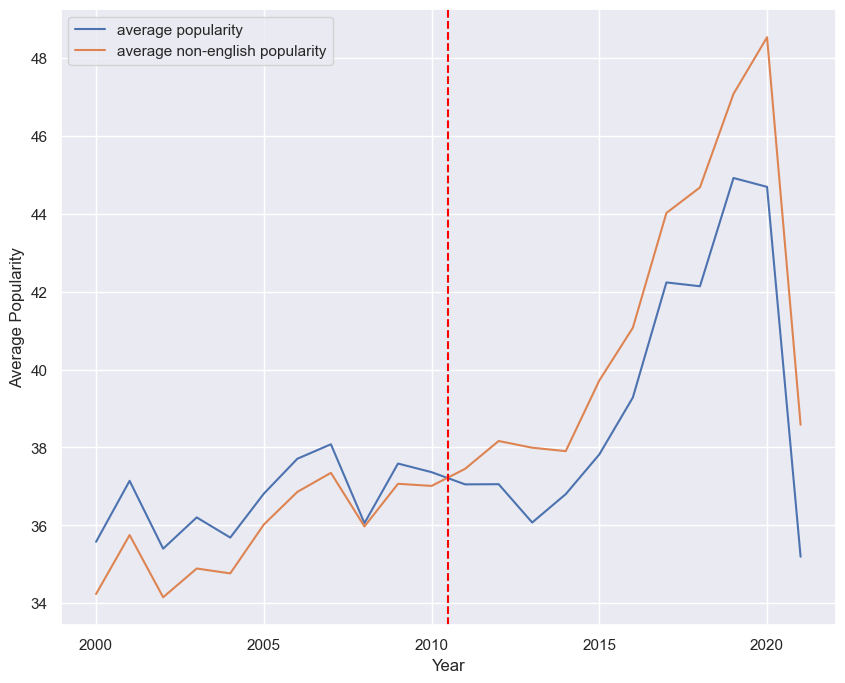

In [26]:
#look more closely at 2000 and on
year_pop = tracks[tracks['release_year'] >= 2000].groupby('release_year')['popularity'].mean()
year_pop_non_en = tracks[(tracks['release_year'] >= 2000) & (tracks['en'] == 0)].groupby('release_year')['popularity'].mean()

sns.set(style='darkgrid')
plt.figure(figsize=(10,8))
sns.lineplot(x=year_pop.index, y=year_pop.values, label='average popularity')
sns.lineplot(x=year_pop_non_en.index, y=year_pop_non_en.values, label='average non-english popularity')
plt.axvline(x=2010.5, color='red', linestyle='--')
plt.xlabel("Year")
plt.ylabel("Average Popularity")
plt.legend()
plt.show(); 

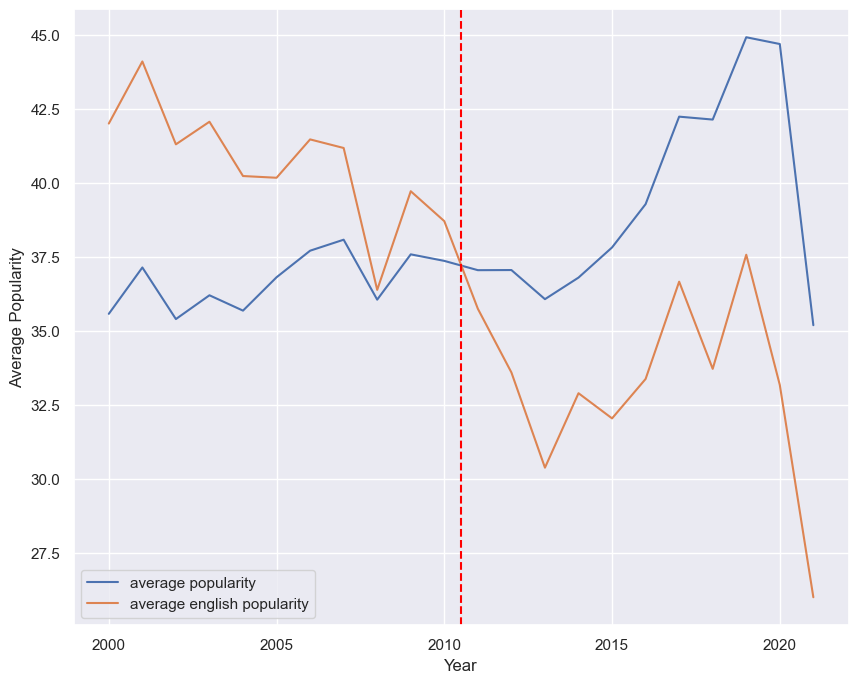

In [27]:
#look at english music compared to overall popularity
year_pop_en = tracks[(tracks['release_year'] >= 2000) & (tracks['en'] == 1)].groupby('release_year')['popularity'].mean()

sns.set(style='darkgrid')
plt.figure(figsize=(10,8))
sns.lineplot(x=year_pop.index, y=year_pop.values, label='average popularity')
sns.lineplot(x=year_pop_en.index, y=year_pop_en.values, label='average english popularity')
plt.axvline(x=2010.5, color='red', linestyle='--')

plt.xlabel("Year")
plt.ylabel("Average Popularity")
plt.legend()
plt.show(); 

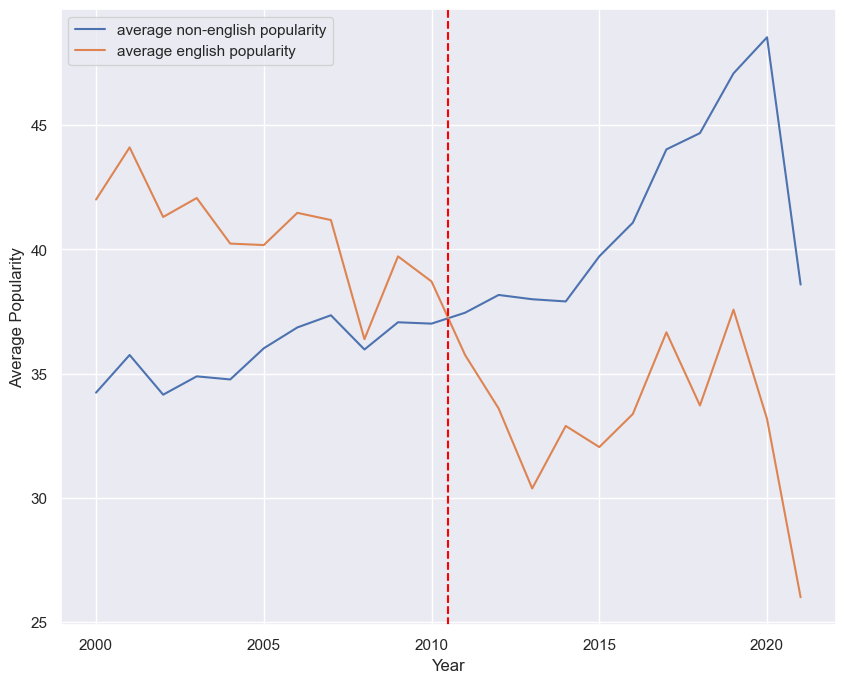

In [28]:
#look at average English popularity against Non-English popularity
sns.set(style='darkgrid')
plt.figure(figsize=(10,8))
sns.lineplot(x=year_pop_non_en.index, y=year_pop_non_en.values, label='average non-english popularity')
sns.lineplot(x=year_pop_en.index, y=year_pop_en.values, label='average english popularity')
plt.axvline(x=2010.5, color='red', linestyle='--')

plt.xlabel("Year")
plt.ylabel("Average Popularity")
plt.legend()
plt.show(); 

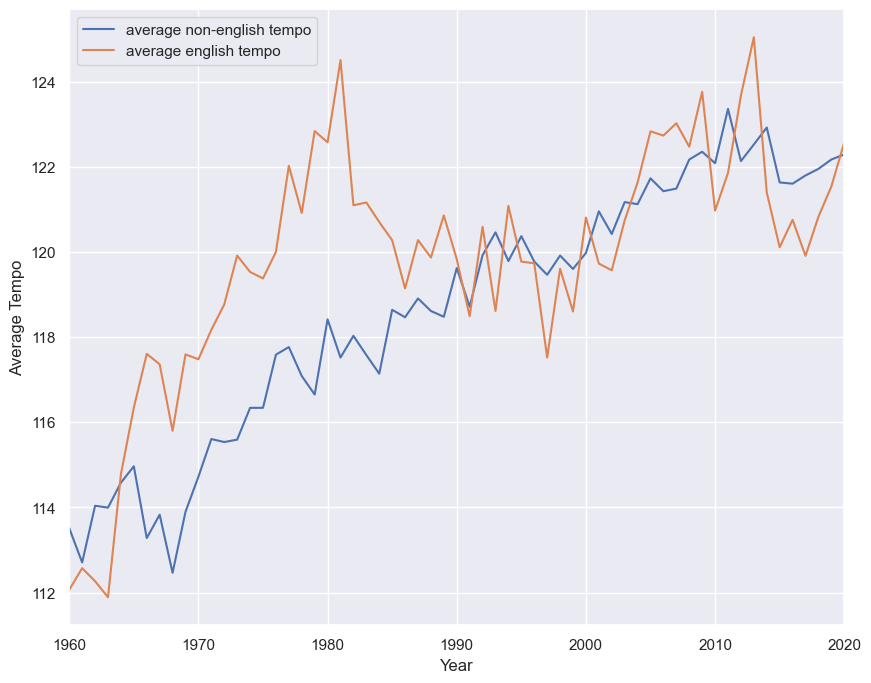

In [29]:
#look at average English danceability 
year_dance_en = tracks[(tracks['release_year'] >= 1960) & (tracks['en'] == 1)].groupby('release_year')['tempo'].mean()
year_dance_non_en = tracks[(tracks['release_year'] >= 1960) & (tracks['en'] == 0)].groupby('release_year')['tempo'].mean()

sns.set(style='darkgrid')
plt.figure(figsize=(10,8))
sns.lineplot(x=year_dance_non_en.index, y=year_dance_non_en.values, label='average non-english tempo')
sns.lineplot(x=year_dance_en.index, y=year_dance_en.values, label='average english tempo')
#plt.axvline(x=2010.5, color='red', linestyle='--')

plt.xlabel("Year")
plt.ylabel("Average Tempo")
plt.xlim(1960, 2020)
plt.legend()
plt.show(); 

There is a significant change in average popularity in between 2010 and 2011, where the average popularity of non-english music surpasses that of English music. This trend shows us that there is a growing appetite for non-English music.

In [30]:
#drop 'en' category before modeling process 
tracks.drop('en', axis=1, inplace=True)

# Modeling

## Pre-Processing for Clustering
Now that we have a better understanding of what our dataset contains, we can appropriately preprocess the data in order to use it to train a KMeans Clustering model. Through this, we will hopefully find underlying patterns within our dataset and identify important features. 

### Feature Scaling

In [31]:
from sklearn.preprocessing import MinMaxScaler

to_scale = tracks[['popularity', 'duration_ms', 'loudness', 'tempo']]
scaler = MinMaxScaler()
scaled_data_ = scaler.fit_transform(to_scale)
scaled_data = pd.DataFrame(scaled_data_, columns=to_scale.columns)

#check that all maximums = 1 and all minimums = 0 
scaled_data.describe()

,popularity,duration_ms,loudness,tempo
count,586547.000000,586547.000000,586547.000000,586547.000000
mean,0.275730,0.040355,0.761658,0.480830
std,0.183696,0.022524,0.077847,0.120798
min,0.000000,0.000000,0.000000,0.000000
25%,0.130000,0.030570,0.720586,0.388041
50%,0.270000,0.037659,0.776401,0.476445
75%,0.410000,0.046374,0.818626,0.553306
max,1.000000,1.000000,1.000000,1.000000


In [32]:
#remove original columns and add our scaled features
tracks_scaled = tracks.drop(to_scale.columns, axis=1)
tracks_scaled_ = pd.concat([tracks_scaled, scaled_data], axis=1)

### Encode Categorical Columns 

In [33]:
from sklearn.preprocessing import OneHotEncoder

to_encode = tracks_scaled_[['key', 'mode', 'time_signature', 'decade', 'name_language']]
encoder = OneHotEncoder(drop='first')
encoder.fit(to_encode)
data_encoded = pd.DataFrame(encoder.transform(to_encode).todense(), columns=encoder.get_feature_names_out())

tracks_scaled_encoded = pd.concat([tracks_scaled_, data_encoded], axis=1)
tracks_scaled_encoded.drop(['key', 'mode', 'time_signature', 'decade', 'name_language'], axis=1, inplace=True)
preprocessed_k = tracks_scaled_encoded.drop(['id', 'name', 'artists', 'id_artists', 'length_formatted', 'release_year', 'artist_name_1', 'artist_name_2', 'artist_name_3'], axis=1)

In [34]:
#check final pre-processed dataframe 
preprocessed_k.head()

,explicit,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,popularity,duration_ms,loudness,tempo,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5,decade_1920,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,decade_2020,name_language_ar,name_language_bg,name_language_ca,name_language_cs,name_language_cy,name_language_da,name_language_de,name_language_el,name_language_en,name_language_es,name_language_et,name_language_fa,name_language_fi,name_language_fr,name_language_he,name_language_hr,name_language_hu,name_language_id,name_language_it,name_language_ja,name_language_ko,name_language_lt,name_language_lv,name_language_mk,name_language_nl,name_language_no,name_language_pl,name_language_pt,name_language_ro,name_language_ru,name_language_sk,name_language_sl,name_language_so,name_language_sq,name_language_sv,name_language_sw,name_language_th,name_language_tl,name_language_tr,name_language_uk,name_language_ur,name_language_vi,name_language_zh-cn,name_language_zh-tw
0,0,0.645,0.4450,0.4510,0.674,0.7440,0.151,0.127,0.06,0.021994,0.713748,0.425564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.695,0.2630,0.9570,0.797,0.0000,0.148,0.655,0.00,0.016885,0.579173,0.414029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.434,0.1770,0.0512,0.994,0.0218,0.212,0.457,0.00,0.031737,0.593796,0.529335,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.321,0.0946,0.0504,0.995,0.9180,0.104,0.397,0.00,0.030895,0.490073,0.689907,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.402,0.1580,0.0390,0.989,0.1300,0.311,0.196,0.00,0.028434,0.659263,0.418945,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Baseline Clustering Model

In [35]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=10, n_init=10, random_state=42)
k_means.fit(preprocessed_k)

KMeans(n_clusters=10, n_init=10, random_state=42)

Because we have a large dataset, Silhouette Score will be too computationally taxing to calculate. Instead we will use the Calinski-Harabasz Score and distortion to measure our clustering.

In [36]:
baseline_clusters = k_means.labels_
from sklearn.metrics import calinski_harabasz_score, silhouette_score
print(calinski_harabasz_score(preprocessed_k, baseline_clusters))

26225.53215195765


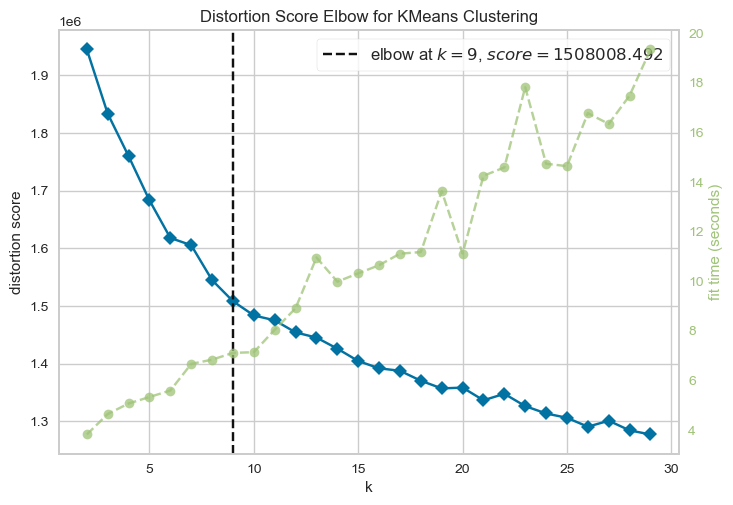

In [37]:
# Elbow Method using distortion 

from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init=10, random_state=42)
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(preprocessed_k)        
visualizer.show();        

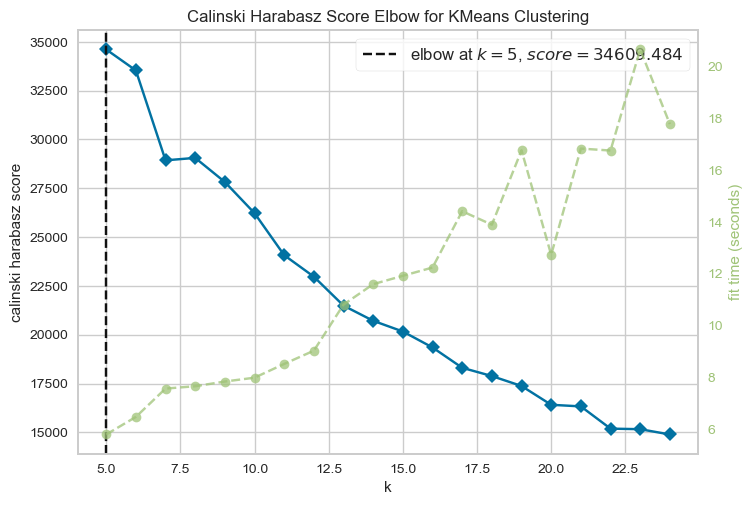

In [38]:
# Elbow Method using Calinski-Harabasz Score

from yellowbrick.cluster import KElbowVisualizer
model = KMeans(n_init=10, random_state=42) 
visualizer = KElbowVisualizer(model, k=(5,25), metric='calinski_harabasz', timings= True)
visualizer.fit(preprocessed_k)        
visualizer.show();        

Our Calinski-Harabasz elbow doesn't appear to have a very definite elbow, so we can use the elbow of our distortion graph and set k = 9. 

In [39]:
#baseline with random state 
baseline_score = k_means.inertia_ 

model_2 = KMeans(n_init=10, random_state=42, n_clusters=9)
model_2.fit(preprocessed_k)
print(model_2.inertia_)

1508008.5212932762


In [40]:
(model_2.inertia_ - baseline_score) / model_2.inertia_

0.016360983202003507

By changing the number of clusters to 9, our model's inertia decreased by about 1.6% 

### Feature Importance (Random Forest)

In order to gain more insights about the patterns in our data, we will further explore the clusters made from our K-Means model. By using a Random Forest Classifier and setting our labels as the target, we can extract feature importance for each cluster in order to see which variables are most significant in our data. 

(note: this method comes from the blog towardsdatascience: https://towardsdatascience.com/interpretable-k-means-clusters-feature-importances-7e516eeb8d3c)

Steps:
1. Change the cluster labels into One-vs-All binary labels for each
2. Train a classifier to discriminate between each cluster and all other clusters
3. Extract the feature importances from the model 


In [41]:
#create binary arrays for each cluster

binary_series = pd.DataFrame(model_2.labels_, columns = ['cluster'])
binary_array_list = []

def make_binary(i):
    df = binary_series['cluster'].apply(lambda x: 1 if x == i else 0)
    values = df.values
    binary_array_list.append(values)

for i in range(0, 9):
    make_binary(i)


In [42]:
#sanity check
assert len(binary_array_list) == 9
assert sum(binary_array_list[0]) == 48421

In [43]:
#create a random forest classifier using cluster label 0 as the target
 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42, max_depth=10)
clf.fit(preprocessed_k, binary_array_list[0])

#extract features and corresponding importances 
importances = clf.feature_importances_
features = clf.feature_names_in_
named_importances = list(zip(features, importances))

#order features by most important 
sorted_list = sorted(named_importances, key=lambda x: x[1], reverse=True)
sorted_list[:10]

[('mode_1', 0.34766849500787755),
 ('decade_2010', 0.3172014318930742),
 ('decade_2020', 0.0705646988985114),
 ('popularity', 0.03975159576843819),
 ('decade_2000', 0.03546889253782263),
 ('loudness', 0.02820957895074467),
 ('decade_1990', 0.02377624428425558),
 ('energy', 0.015373533854990202),
 ('decade_1980', 0.01471366202039249),
 ('acousticness', 0.013631191830964052)]

In [44]:
#create function to extract feature importances from all clusters 

features_list = []

def get_features(binary):
    clf = RandomForestClassifier(random_state=42, max_depth=10)
    clf.fit(preprocessed_k, binary)
    importances = clf.feature_importances_
    feature = clf.feature_names_in_
    named_importances = list(zip(feature, importances))
    sorted_list = sorted(named_importances, key=lambda x: x[1], reverse=True)
    features_list.append(sorted_list)

for binary in binary_array_list:
    get_features(binary)


In [45]:
#print top ten features for each cluster
for i, features in enumerate(features_list):
    print(f'Cluster {i}:')
    print(features[:10])

Cluster 0:
[('mode_1', 0.34766849500787755), ('decade_2010', 0.3172014318930742), ('decade_2020', 0.0705646988985114), ('popularity', 0.03975159576843819), ('decade_2000', 0.03546889253782263), ('loudness', 0.02820957895074467), ('decade_1990', 0.02377624428425558), ('energy', 0.015373533854990202), ('decade_1980', 0.01471366202039249), ('acousticness', 0.013631191830964052)]
Cluster 1:
[('decade_1960', 0.7133872642630678), ('time_signature_3', 0.06165231529794486), ('time_signature_4', 0.03364709297460159), ('popularity', 0.024283045850658456), ('duration_ms', 0.020999572209466598), ('decade_1990', 0.020137760884941694), ('decade_1980', 0.01723958101507013), ('decade_1970', 0.014547025801386771), ('decade_2010', 0.014395446980580064), ('acousticness', 0.013698507508997614)]
Cluster 2:
[('decade_2000', 0.6993311695776497), ('decade_2010', 0.04683244308332584), ('decade_1990', 0.04287221199498979), ('loudness', 0.03641241308790453), ('decade_1980', 0.03273158855558439), ('popularity', 0

By examing the top ten features from each cluster, we see that the features we see that our model uses many of the same features to split. It mostly uses decades, time signatures, popularity, and other subjective sound qualities such as 'acousticness' or 'danceability.'

It's interesting to note that there are no clusters with any language feature as a top split. This indicates that the language of the song is less indicative of the musical qualities of the music than we may assume. Instead, the decade of the track appears to be more determining of its qualities. 

We can also examine the splits of different languages in each cluster to see the amount of variance: 


In [46]:
#create dataframe with cluster labels

tracks_clustered = tracks.copy()
tracks_clustered['cluster'] = model_2.labels_

In [47]:
tracks_clustered['name_language'].value_counts(normalize=True)[:10]

en    0.244255
es    0.079114
it    0.060343
pt    0.045043
fr    0.037034
de    0.031459
id    0.031167
fi    0.028925
tl    0.026895
da    0.025509
Name: name_language, dtype: float64

In [48]:
for i in range(0,9): 
    print(i)
    print(tracks_clustered[tracks_clustered['cluster'] == i]['name_language'].value_counts(normalize=True)[:5])


0
en    0.223147
es    0.065509
it    0.059747
pt    0.039735
fr    0.038723
Name: name_language, dtype: float64
1
en    0.360733
es    0.059809
it    0.058934
pt    0.046092
fr    0.043287
Name: name_language, dtype: float64
2
en    0.183895
es    0.095189
it    0.055080
pt    0.050680
id    0.037766
Name: name_language, dtype: float64
3
en    0.239830
es    0.074356
de    0.056168
it    0.050672
pt    0.039830
Name: name_language, dtype: float64
4
en    0.189255
es    0.103375
it    0.056916
pt    0.049355
fr    0.034141
Name: name_language, dtype: float64
5
en    0.215159
es    0.088365
de    0.075797
it    0.067177
fr    0.037645
Name: name_language, dtype: float64
6
en    0.238958
es    0.074913
it    0.051610
pt    0.044067
fr    0.033076
Name: name_language, dtype: float64
7
en    0.296936
es    0.070536
it    0.056748
pt    0.054169
fr    0.036595
Name: name_language, dtype: float64
8
en    0.350891
it    0.091491
es    0.050057
fr    0.046799
pt    0.041484
Name: name_language

By looking at the value counts of languages in each individual cluster, we can see the top languages remain relatively consistent with the top languages of the overall dataset. 

Cluster 1 and Cluster 8 show an increase of about 10% in the split of English tracks. Looking back at their most important features, Cluster 1 used 'decade_1960' as the most important feature (0.71) and Cluster 8 used 'decade_1950' (0.25249946567155157). This could be indicative of a higher correlation between track qualities and whether they are in English, or it could be due to a higher amount of English music in our dataset from earlier decades. 

## Building a Content-Based Recommender System

In [49]:

vectorized_songs = preprocessed_k.drop(['name_language_ar', 'name_language_bg', 'name_language_ca', 'name_language_cs', 'name_language_cy', 'name_language_da', 'name_language_de', 'name_language_el', 'name_language_en', 'name_language_es', 'name_language_et', 'name_language_fa', 'name_language_fi', 'name_language_fr', 'name_language_he', 'name_language_hr', 'name_language_hu', 'name_language_id', 'name_language_it', 'name_language_ja', 'name_language_ko', 'name_language_lt', 'name_language_lv', 'name_language_mk', 'name_language_nl', 'name_language_no', 'name_language_pl', 'name_language_pt', 'name_language_ro', 'name_language_ru', 'name_language_sk', 'name_language_sl', 'name_language_so', 'name_language_sq', 'name_language_sv', 'name_language_sw', 'name_language_th', 'name_language_tl', 'name_language_tr', 'name_language_uk', 'name_language_ur', 'name_language_vi', 'name_language_zh-cn', 'name_language_zh-tw'], axis=1)
vectorized_songs_ = vectorized_songs.values.tolist()

In [50]:
#sanity check 
assert len(vectorized_songs_) == len(preprocessed_k)
assert len(vectorized_songs_[0]) == len(vectorized_songs.columns)

In [51]:
from annoy import AnnoyIndex

num_dimensions = len(vectorized_songs.columns)  # 
annoy_index = AnnoyIndex(num_dimensions, 'euclidean')  
# Add songs to the index
for song_id, song_vector in enumerate(vectorized_songs_):
    annoy_index.add_item(song_id, song_vector)

# Build the index
n_trees = 100
annoy_index.build(n_trees)  

True

In [52]:
# Choose the number of dimensions in your vectors (should match the dimensionality of your vectors)
num_dimensions = len(vectorized_songs.columns)  # Replace with the actual number of dimensions
annoy_index = AnnoyIndex(num_dimensions, 'euclidean')  # You can use 'angular' or 'dot' for cosine similarity

# Add songs to the index
for song_id, song_vector in enumerate(vectorized_songs_):
    annoy_index.add_item(song_id, song_vector)

# Build the index
n_trees = 100
annoy_index.build(n_trees)  # n_trees is a parameter that affects search speed vs accuracy

True

Our example track we will use is "We Found Love" by Rihanna, a popular English-language song 

In [53]:
target_song_id = 84115
num_neighbors = 20

target_song_vector = vectorized_songs_[target_song_id]
neighbor_indices = annoy_index.get_nns_by_vector(target_song_vector, num_neighbors)

# Retrieve the recommended songs from the DataFrame
recommended_songs = tracks.iloc[neighbor_indices]

In [54]:
recommended_songs[['name', 'artists']]

,name,artists
84115,we found love,"['Rihanna', 'Calvin Harris']"
84096,we found love,"['Rihanna', 'Calvin Harris']"
90173,body,"['Loud Luxury', 'Brando']"
303966,latch,"['Disclosure', 'Sam Smith']"
444225,body,"['Loud Luxury', 'Brando']"
91774,my blood,['Twenty One Pilots']
488067,body,"['Loud Luxury', 'Brando']"
83230,cannibal,['Kesha']
279547,no one compares to you,['Jack & Jack']
85999,we found love,"['Rihanna', 'Calvin Harris']"


In [55]:
#try again with more trees
# Choose the number of dimensions in your vectors (should match the dimensionality of your vectors)
num_dimensions = len(vectorized_songs.columns)  # Replace with the actual number of dimensions
annoy_index = AnnoyIndex(num_dimensions, 'euclidean')  # You can use 'angular' or 'dot' for cosine similarity

# Add songs to the index
for song_id, song_vector in enumerate(vectorized_songs_):
    annoy_index.add_item(song_id, song_vector)

# Build the index
n_trees = 150
annoy_index.build(n_trees)  # n_trees is a parameter that affects search speed vs accuracy


True

In [56]:

target_song_id = 84115
num_neighbors = 30

target_song_vector = vectorized_songs_[target_song_id]
neighbor_indices = annoy_index.get_nns_by_vector(target_song_vector, num_neighbors)

# Retrieve the recommended songs from the DataFrame
recommended_songs_tuned = tracks.iloc[neighbor_indices]

recommended_songs_tuned.drop_duplicates(subset='name')[['name', 'artists']]

,name,artists
84115,we found love,"['Rihanna', 'Calvin Harris']"
90173,body,"['Loud Luxury', 'Brando']"
303966,latch,"['Disclosure', 'Sam Smith']"
91774,my blood,['Twenty One Pilots']
83230,cannibal,['Kesha']
279547,no one compares to you,['Jack & Jack']
337114,9 and three quarters - run away,['TOMORROW X TOGETHER']
88978,24k magic,['Bruno Mars']
305111,london boy,['Taylor Swift']
89219,save me,['BTS']


In [57]:
import numpy as np
from scipy.spatial.distance import euclidean

# Vectorized features of the target song and recommended songs
target_song_vector = vectorized_songs_[target_song_id]
recommended_song_vectors = [vectorized_songs_[i] for i in neighbor_indices]  

# Calculate similarity (lower distance means more similarity)
similarity_scores = [1 / (1 + euclidean(target_song_vector, recommended_song_vector))
                     for recommended_song_vector in recommended_song_vectors]

# Print similarity scores for recommended songs
for song_index, similarity_score in enumerate(similarity_scores):
    print(f"Recommended Song {song_index + 1} Similarity: {similarity_score}")


Recommended Song 1 Similarity: 1.0
Recommended Song 2 Similarity: 0.9900501186375844
Recommended Song 3 Similarity: 0.9352130767033552
Recommended Song 4 Similarity: 0.9095655248717904
Recommended Song 5 Similarity: 0.891915325261812
Recommended Song 6 Similarity: 0.8847878682607366
Recommended Song 7 Similarity: 0.8785807975843664
Recommended Song 8 Similarity: 0.8785700406886365
Recommended Song 9 Similarity: 0.8772524823751414
Recommended Song 10 Similarity: 0.8771902343562156
Recommended Song 11 Similarity: 0.8751384624142013
Recommended Song 12 Similarity: 0.8718653585599175
Recommended Song 13 Similarity: 0.8685816646523821
Recommended Song 14 Similarity: 0.8685816646523821
Recommended Song 15 Similarity: 0.8638961387388839
Recommended Song 16 Similarity: 0.8609945831666584
Recommended Song 17 Similarity: 0.8587580578760657
Recommended Song 18 Similarity: 0.858427097590021
Recommended Song 19 Similarity: 0.8575476457689545
Recommended Song 20 Similarity: 0.8532644488872149
Recomm

In [58]:
#try again with cosine similarity
# Choose the number of dimensions in your vectors (should match the dimensionality of your vectors)
num_dimensions = len(vectorized_songs.columns)  # Replace with the actual number of dimensions
annoy_index_dot = AnnoyIndex(num_dimensions, 'dot')  # You can use 'angular' or 'dot' for cosine similarity

# Add songs to the index
for song_id, song_vector in enumerate(vectorized_songs_):
    annoy_index_dot.add_item(song_id, song_vector)

# Build the index
n_trees = 100
annoy_index_dot.build(n_trees)  # n_trees is a parameter that affects search speed vs accuracy

target_song_id = 84115
num_neighbors = 30

target_song_vector = vectorized_songs_[target_song_id]
neighbor_indices = annoy_index_dot.get_nns_by_vector(target_song_vector, num_neighbors)

# Retrieve the recommended songs from the DataFrame
recommended_songs_2 = tracks.iloc[neighbor_indices]


In [59]:
tracks.iloc[84115]

id                                             0U10zFw4GlBacOy9VDGfGL
name                                                    we found love
popularity                                                         75
duration_ms                                                    215227
explicit                                                            0
artists                                  ['Rihanna', 'Calvin Harris']
id_artists          ['5pKCCKE2ajJHZ9KAiaK11H', '7CajNmpbOovFoOoasH...
danceability                                                    0.735
energy                                                          0.766
key                                                                 1
loudness                                                       -4.485
mode                                                                1
speechiness                                                    0.0383
acousticness                                                    0.025
instrumentalness    

In [60]:
recommended_songs_2[['name', 'artists']]

,name,artists
158129,rebota,['Guaynaa']
438654,relógio parado (ao vivo),['Diego & Arnaldo']
211431,tra tra tra remix - remix,"['Ghetto Kids', 'Guaynaa', 'Mad Fuentes']"
90838,perro fiel (feat. nicky jam),"['Shakira', 'Nicky Jam']"
357119,welcome 2 hell,['Bad Meets Evil']
85469,survival tactics,"['Joey Bada$$', 'Capital Steez']"
303459,cuando me enamoro,"['Enrique Iglesias', 'Juan Luis Guerra 4.40']"
83351,cuando me enamoro,"['Enrique Iglesias', 'Juan Luis Guerra 4.40']"
87903,rude (acoustic),['MAGIC!']
156265,me enamoré,['Angel Y Khriz']


In [61]:
#calculate the cosine similarity between songs and the target song 
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

# Vectorized features of the target song and recommended songs
target_song_vector = vectorized_songs_[target_song_id]
recommended_song_vectors = [vectorized_songs_[i] for i in neighbor_indices]

# Calculate cosine similarity scores
similarity_scores = [1 - cosine_distances([target_song_vector], [recommended_song_vector])[0][0]
                     for recommended_song_vector in recommended_song_vectors]

# Print similarity scores for recommended songs
for song_index, similarity_score in enumerate(similarity_scores):
    print(f"Recommended Song {song_index + 1} Similarity: {similarity_score}")


Recommended Song 1 Similarity: 0.9774424213658917
Recommended Song 2 Similarity: 0.952073431083228
Recommended Song 3 Similarity: 0.9898081798406176
Recommended Song 4 Similarity: 0.9880408081811854
Recommended Song 5 Similarity: 0.9243585465723256
Recommended Song 6 Similarity: 0.9120886855557369
Recommended Song 7 Similarity: 0.9936194101360623
Recommended Song 8 Similarity: 0.9936683994720733
Recommended Song 9 Similarity: 0.9849206743738339
Recommended Song 10 Similarity: 0.9848982021929245
Recommended Song 11 Similarity: 0.9847377612432706
Recommended Song 12 Similarity: 0.9974761490734035
Recommended Song 13 Similarity: 0.9882150733810616
Recommended Song 14 Similarity: 0.9906036325014749
Recommended Song 15 Similarity: 0.9897952182119054
Recommended Song 16 Similarity: 0.9859723820716567
Recommended Song 17 Similarity: 0.9904717867434331
Recommended Song 18 Similarity: 0.9845111525529676
Recommended Song 19 Similarity: 0.9936699777600384
Recommended Song 20 Similarity: 0.9913293

By using cosine similarity as our metric of significance, our simple content-based model can recommend songs that are extremley similar, while also providing a wide range of langauges. 

# Conclusion
By analzying a large and diverse dataset of tracks from Spotify, we can see the significant trend of the last decade of increased popularity of non-English music and the decrease in popularity of English music. By digging in further through different models, we can also see that language does not appear to be a significant indiactor of audio similarity (based on the audio measures tracked by Spotify). For our purposes of building a recommender system with less bias against non-English music, this means that we should remove or minimize language or other location based features when training our system. Through this, we can hopefully recommend music to users that they will enjoy, but is not confined to certain language barriers. 